# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from Kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications, we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from warnings import filterwarnings 
filterwarnings('ignore')
from pyvin import VIN


from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, LogisticRegression, RidgeCV, LassoCV, Ridge, Lasso
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder, OrdinalEncoder, StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error 
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, cross_val_score
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.decomposition import PCA
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.feature_selection import mutual_info_classif
import category_encoders as ce


from sklearn import set_config
set_config(display="diagram") #setting this will display the pipelines as seen above

In [2]:
df = pd.read_csv('data/vehicles.csv')

In [3]:
df.head()

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
0,7222695916,prescott,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az
1,7218891961,fayetteville,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar
2,7221797935,florida keys,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl
3,7222270760,worcester / central MA,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ma
4,7210384030,greensboro,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nc


### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

In [7]:
#There seems to be 426880 rows in the data based on the number of id.
#A few non-null values for odometer reading and year exist and these rows can be removed as these are important features in used car sales.

### Data Preparation

After our initial exploration and fine-tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

In [19]:
#Drop rows with no odometer and no year reading as this is important feature in this analysis
df = df.dropna(subset=['year', 'odometer'])

In [21]:
#Convert odometer to integer
df['odometer'] = df['odometer'].astype(np.int64)

In [23]:
#Add a new column 'age' that represents the age of the vehicle

current_year = datetime.datetime.now().year #get current year@

df['Current Year'] = datetime.datetime.now().year
df['age'] = df['Current Year'] - df['year']  # substract to get the year delta

In [25]:
#Convert year from float to date and drop Current Year
df['year'] = pd.to_datetime(df['year'], format = "%Y").dt.strftime('%Y')
df.drop('Current Year', axis=1, inplace=True)

In [26]:
df = df.reset_index(drop=True)

In [27]:
#Identifying unique vehicle types
unique_types = df['type'].unique()
print(unique_types)

['pickup' 'truck' 'other' nan 'coupe' 'SUV' 'hatchback' 'mini-van' 'sedan'
 'offroad' 'bus' 'van' 'convertible' 'wagon']


In [28]:
#Removing rows with 'other' and 'nan' as vehicle types
df = df.dropna(subset=['type'])
df = df.drop(df[df['type'] == 'other'].index)

In [86]:
#Removing rows with 'nan' as price
df = df.dropna(subset=['price'])

NameError: name 'df' is not defined

In [29]:
#Identifying unique title_status
unique_titles = df['title_status'].unique()
print(unique_titles)

['clean' 'rebuilt' 'lien' nan 'salvage' 'missing' 'parts only']


In [30]:
#Removing rows with 'parts only', 'missing', and 'nan' as title_status
df = df.dropna(subset=['title_status'])
df = df.drop(df[df['title_status'] == 'parts only'].index)
df = df.drop(df[df['title_status'] == 'missing'].index)

In [31]:
#Identifying unique condition
unique_titles = df['condition'].unique()
print(unique_titles)

['good' 'excellent' 'fair' 'like new' 'new' nan 'salvage']


In [32]:
#Removing rows with 'salvage', and 'nan' as condition
df = df.dropna(subset=['condition'])
df = df.drop(df[df['condition'] == 'salvage'].index)

In [33]:
#Removing rows with 'nan' as cylinders
df = df.dropna(subset=['cylinders'])

In [36]:
#Removing rows with 'nan' as VIN number
df = df.dropna(subset=['VIN'])

In [40]:
#Removing rows with 'nan' as manufacturer
df = df.dropna(subset=['manufacturer'])

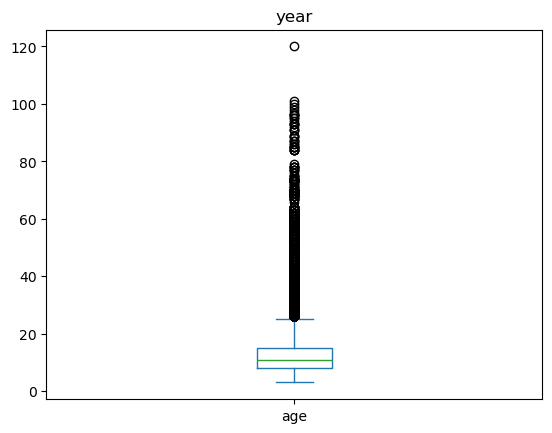

In [47]:
#Verifying data based on age of vehicle
df['age'].plot(kind='box', title='year')
plt.show()

In [49]:
#remove all vehicles that are over 30 years old
df = df.drop(df[df['age'] > 30].index)

In [ ]:
#Identify vehicle model from VIN number
result = []
for row in df.itertuples():
    try:
        Vin_Model = VIN(row.VIN).Model
    except:
        Vin_Model = 'error'
    result.append(Vin_Model)
print(result)

In [ ]:
df['Model'] = result

In [ ]:
#saving df as .csv file
df.to_csv('data/dfVehicles.csv', index=False)

Read from new cleaned dataframe

In [7]:
#Read from new dataframe and remove 'model' column with updated information from 'Model' column
dfVehicles = pd.read_csv('data/dfVehicles.csv')

In [8]:
dfVehicles.head()

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state,age,Model
0,7316814884,auburn,33590,2014,gmc,sierra 1500 crew cab slt,good,8 cylinders,gas,57923,clean,other,3GTP1VEC4EG551563,NaN,NaN,pickup,white,al,11.0,Sierra
1,7316814758,auburn,22590,2010,chevrolet,silverado 1500,good,8 cylinders,gas,71229,clean,other,1GCSCSE06AZ123805,NaN,NaN,pickup,blue,al,15.0,Silverado
2,7316814989,auburn,39590,2020,chevrolet,silverado 1500 crew,good,8 cylinders,gas,19160,clean,other,3GCPWCED5LG130317,NaN,NaN,pickup,red,al,5.0,Silverado
3,7316743432,auburn,30990,2017,toyota,tundra double cab sr,good,8 cylinders,gas,41124,clean,other,5TFRM5F17HX120972,NaN,NaN,pickup,red,al,8.0,Tundra
4,7316343444,auburn,27990,2012,gmc,sierra 2500 hd extended cab,good,8 cylinders,gas,68696,clean,other,1GT220CG8CZ231238,4wd,NaN,pickup,black,al,13.0,Sierra


In [11]:
#Removing rows with 'nan' as price
dfVehicles = dfVehicles.dropna(subset=['price'])

In [13]:
# Filter rows where all values are zero
dfVehicles = dfVehicles[~(dfVehicles['price'] == 0)]

In [15]:
#Replace 'error' in column 'Model' with values from 'model'
dfVehicles['Model'] = np.where(dfVehicles['Model'] == 'error', dfVehicles['model'], dfVehicles['Model'])

In [17]:
#drop 'model' column
df_vehicles = dfVehicles.drop('model', axis=1)

In [19]:
#drop 'year' column
df_vehicles = dfVehicles.drop('year', axis=1)

In [21]:
#drop 'id' column
df_vehicles = dfVehicles.drop('id', axis=1)

In [23]:
#remove all vehicles that are over 20 years old as they are typically classified as classic vehicles
df_vehicles = df_vehicles.drop(df_vehicles[df_vehicles['age'] > 20].index)

In [25]:
#remove all vehicles that have harley-davidson
df_vehicles = df_vehicles.drop(df_vehicles[df_vehicles['manufacturer'] == 'harley-davidson'].index)

In [27]:
#convert cylinders to string as some are int or floats
df_vehicles['cylinders'] = df_vehicles['cylinders'].astype(str)

In [29]:
#Identifying unique manufacturer types
unique_types = df_vehicles['manufacturer'].unique()
print(unique_types)

['gmc' 'chevrolet' 'toyota' 'nissan' 'ford' 'ram' 'jeep' 'lincoln'
 'chrysler' 'infiniti' 'mazda' 'mercedes-benz' 'lexus' 'audi' 'mitsubishi'
 'volkswagen' 'honda' 'hyundai' 'fiat' 'kia' 'cadillac' 'rover' 'dodge'
 'acura' 'mini' 'volvo' 'subaru' 'buick' 'bmw' 'jaguar' 'porsche'
 'alfa-romeo' 'saturn' 'tesla' 'pontiac' 'mercury' 'ferrari'
 'aston-martin']


In [31]:
#Identifying unique vehicle types
unique_types = df_vehicles['type'].unique()
print(unique_types)

['pickup' 'coupe' 'SUV' 'sedan' 'convertible' 'truck' 'hatchback' 'wagon'
 'van' 'mini-van' 'offroad' 'bus']


In [33]:
#Identifying unique cylinders
unique_types = df_vehicles['cylinders'].unique()
print(unique_types)

['8 cylinders' '6 cylinders' '4 cylinders' '5 cylinders' '10 cylinders'
 '3 cylinders' 'other' '12 cylinders']


In [35]:
#Identifying unique fuel
unique_types = df_vehicles['fuel'].unique()
print(unique_types)

['gas' 'other' 'hybrid' 'diesel' 'electric']


In [37]:
#Identifying unique Model
unique_types = df_vehicles['Model'].unique()
print(unique_types)

['Sierra' 'Silverado' 'Tundra' ... 'f150, xlt' 'f150, platinum'
 'cruze, 2lt']


In [39]:
#Identifying unique condition
unique_types = df_vehicles['condition'].unique()
print(unique_types)

['good' 'excellent' 'like new' 'new' 'fair']


In [41]:
#Identifying unique paint color
unique_types = df_vehicles['paint_color'].unique()
print(unique_types)

['white' 'blue' 'red' 'black' 'silver' nan 'brown' 'yellow' 'grey' 'green'
 'custom' 'orange' 'purple']


In [43]:
#Identifying unique transmission
unique_types = df_vehicles['transmission'].unique()
print(unique_types)

['other' 'automatic' 'manual' nan]


In [45]:
#Removing rows with 'transmission' and 'nan'
df_vehicles = df_vehicles.dropna(subset=['transmission'])

In [47]:
#Identifying unique drive
unique_types = df_vehicles['drive'].unique()
print(unique_types)

[nan '4wd' 'rwd' 'fwd']


In [49]:
#Removing rows with drive as 'nan'
df_vehicles = df_vehicles.dropna(subset=['drive'])

In [51]:
#Identifying unique size
unique_types = df_vehicles['size'].unique()
print(unique_types)

[nan 'compact' 'full-size' 'mid-size' 'sub-compact']


In [53]:
#Removing rows with size as 'nan'
df_vehicles = df_vehicles.dropna(subset=['size'])

In [55]:
#Identifying unique state
unique_types = df_vehicles['state'].unique()
print(unique_types)

['al' 'ak' 'az' 'ar' 'ca' 'co' 'ct' 'dc' 'de' 'fl' 'ga' 'hi' 'id' 'il'
 'in' 'ia' 'ks' 'ky' 'la' 'me' 'md' 'ma' 'mi' 'mn' 'ms' 'mo' 'mt' 'nc'
 'ne' 'nv' 'nj' 'nm' 'ny' 'nh' 'nd' 'oh' 'ok' 'or' 'pa' 'ri' 'sc' 'sd'
 'tn' 'tx' 'ut' 'vt' 'va' 'wa' 'wv' 'wi' 'wy']


In [57]:
#remove all vehicles that are over $300,000 in price to remove any outliers
df_vehicles = df_vehicles.drop(df_vehicles[df_vehicles['price'] > 300000].index)

In [59]:
# It appears that a safe cut off odometer reading of 400,000 miles would be good for analysis purposes
df_vehicles = df_vehicles.drop(df_vehicles[df_vehicles['odometer'] > 400000].index)

In [62]:
#Create three dataframes based on vehicle categories
# Group by 'category'
grouped = df_vehicles.groupby('type')

# Create a dictionary to store dataframes
dataframes = {}

# Iterate through groups and create dataframes
for name, group in grouped:
    dataframes[name] = group

features = ['price', 'age', 'odometer', 'manufacturer', 'cylinders', 'fuel', 'Model', 'transmission', 'drive', 'size', 'state']

#Renaming the newly created dataframes and assigning all the relevant features
vehiclesPickup = dataframes['pickup'][features]
vehiclesCoupe = dataframes['coupe'][features]
vehiclesSUV = dataframes['SUV'][features]
vehiclesSedan = dataframes['sedan'][features]
vehiclesConvertible = dataframes['convertible'][features]
vehiclesTruck = dataframes['truck'][features]
vehiclesHatchback = dataframes['hatchback'][features]
vehiclesWagon = dataframes['wagon'][features]
vehiclesVan = dataframes['van'][features]
vehiclesMiniVan = dataframes['mini-van'][features]
vehiclesOffroad = dataframes['offroad'][features]
vehiclesBus = dataframes['bus'][features]

In [64]:
#create a list of the vehicle type dataframes
dfList = ['vehiclesPickup', 'vehiclesCoupe', 'vehiclesSUV', 'vehiclesSedan', 'vehiclesConvertible', 'vehiclesTruck', 'vehiclesHatchback',
          'vehiclesWagon', 'vehiclesVan', 'vehiclesMiniVan', 'vehiclesOffroad', 'vehiclesBus']

### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

Model Building

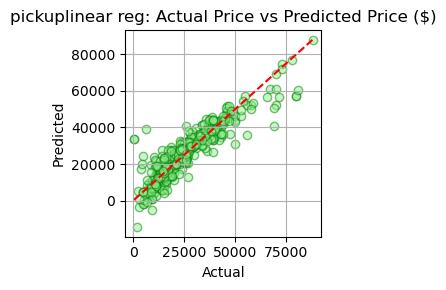

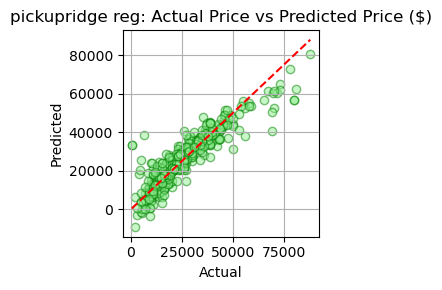

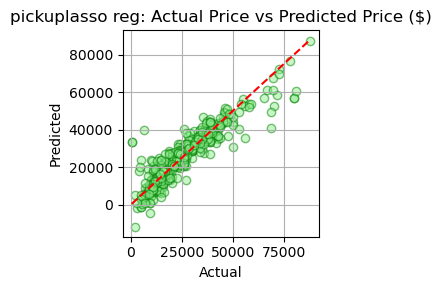

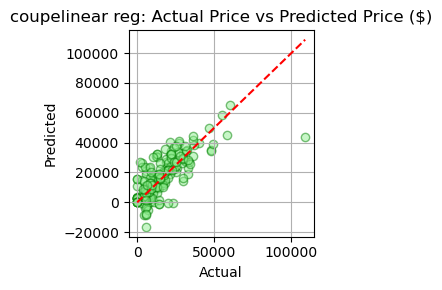

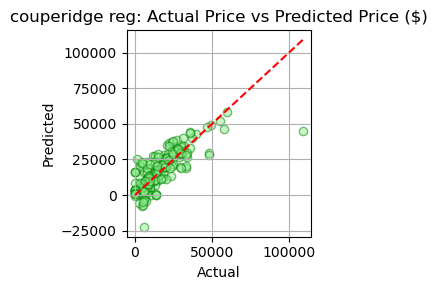

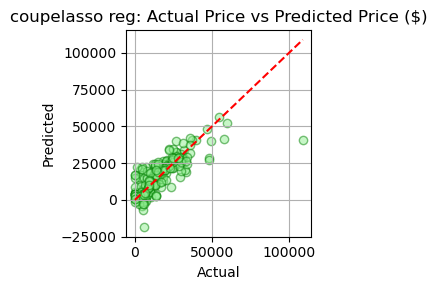

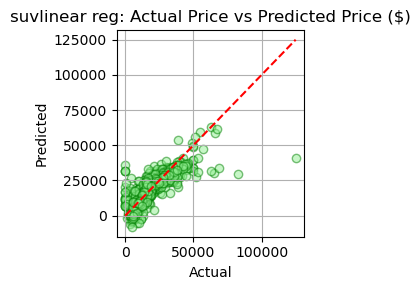

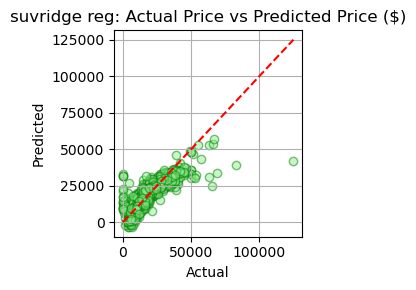

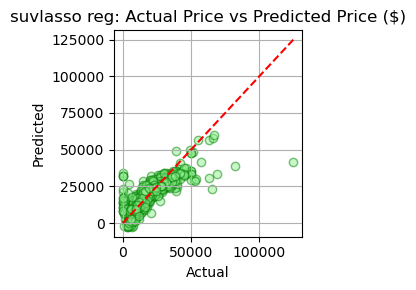

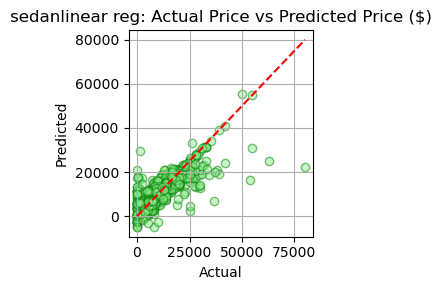

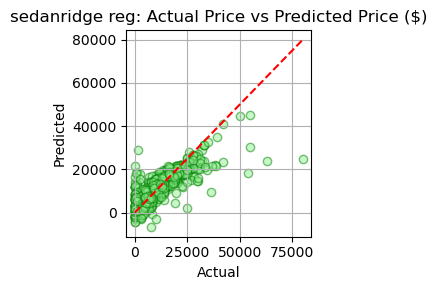

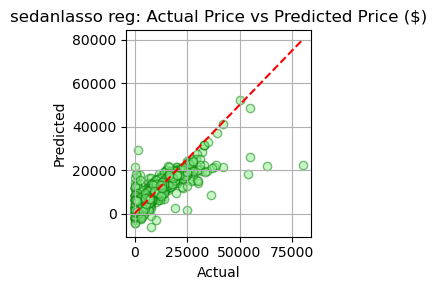

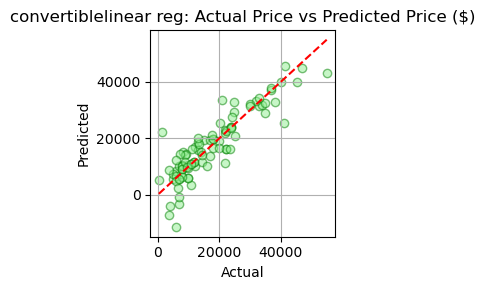

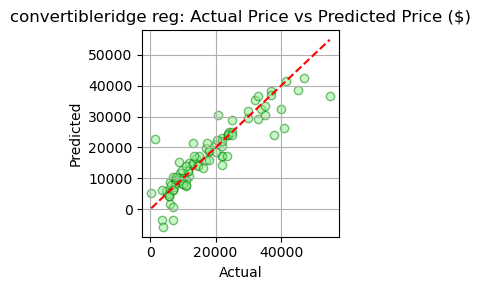

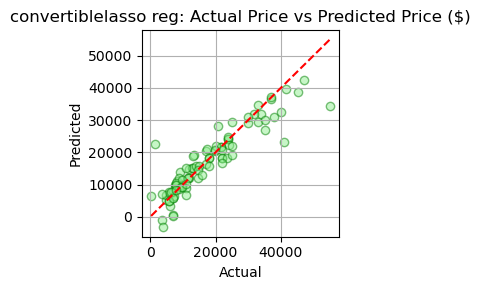

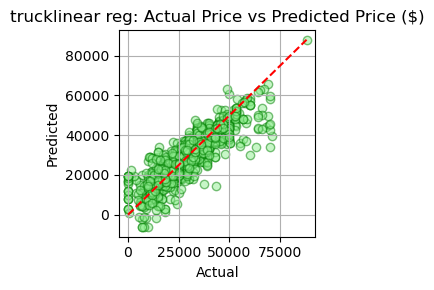

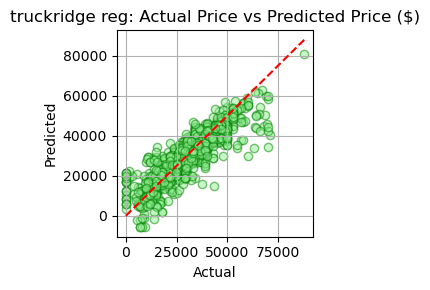

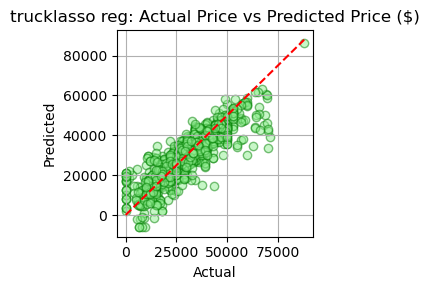

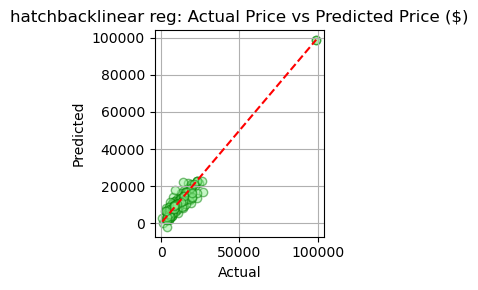

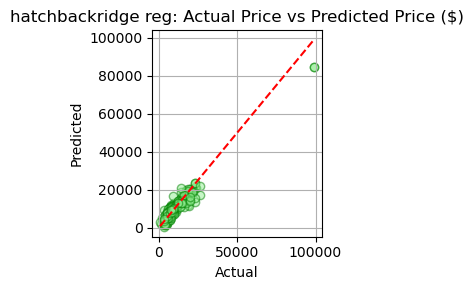

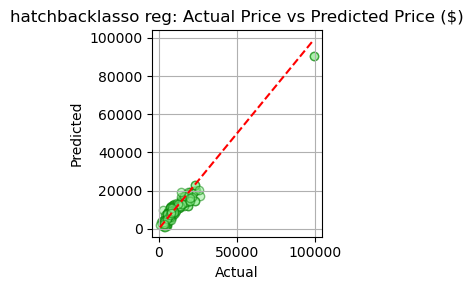

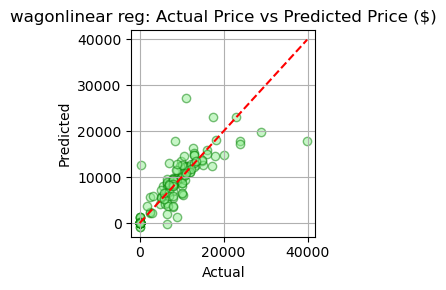

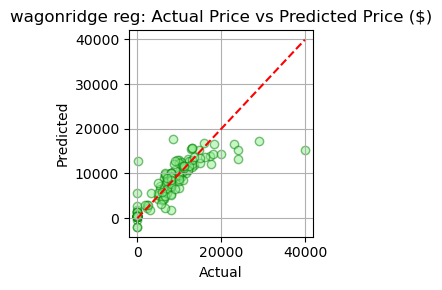

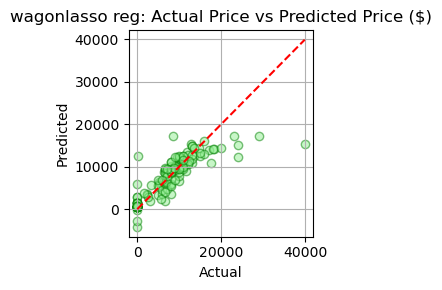

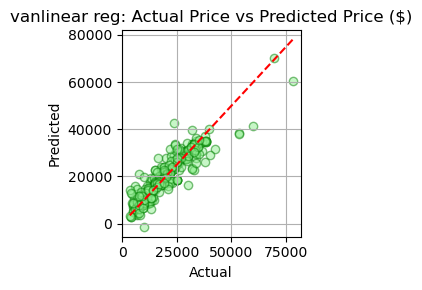

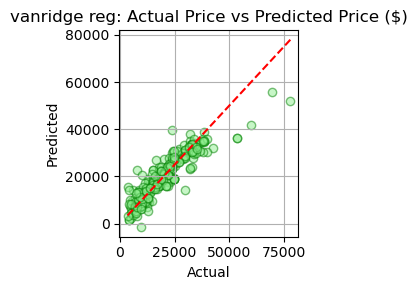

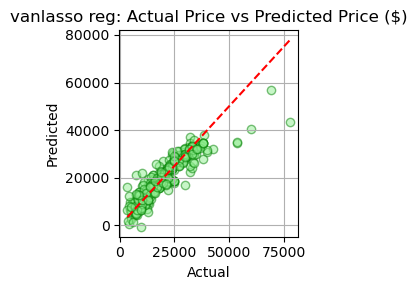

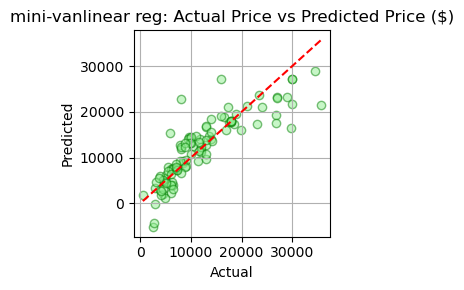

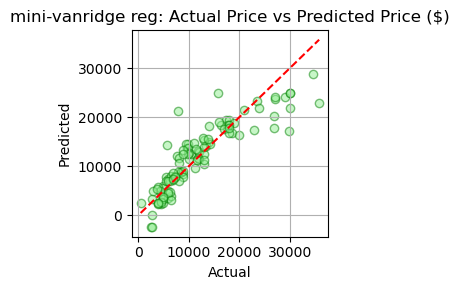

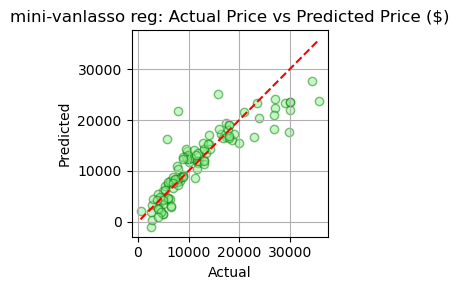

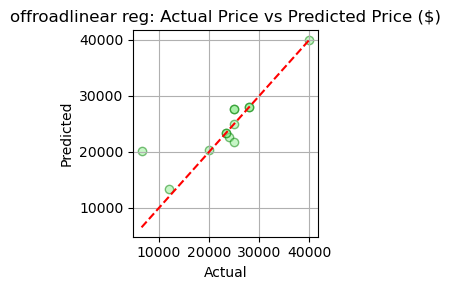

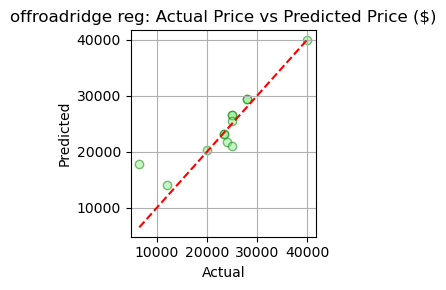

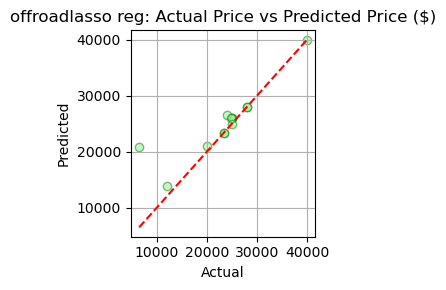

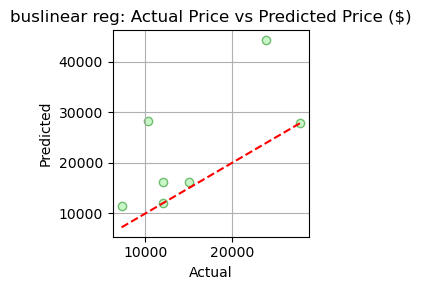

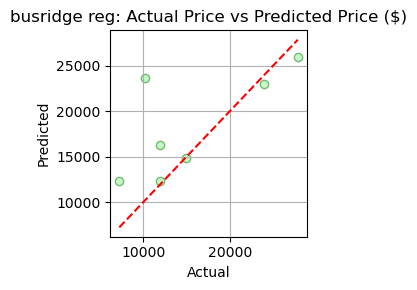

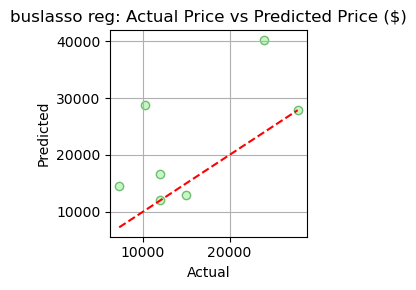

In [145]:
#Models to evaluate, Linear Regression, Ridge Regression, Lasso Regression
Pipe = ['linear', 'ridge', 'lasso']

#initialize empty dataframe
modelsDF = pd.DataFrame()

# Loop through the names and access the DataFrames
for name in dfList:
    df = globals()[name]
    position = 8
    vehiclesplit = name[position:]
    
    if vehiclesplit == 'MiniVan':
        type = 'mini-van'
    else:
        type = vehiclesplit.lower()

    #features and target
    
    train = df
    test = df.drop('price', axis =1)

    X = train.drop('price', axis =1)
    y = train['price']

    #Train test splitting
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state = 42)

    # Building a preprocessing pipeline
    numericalCols = X.select_dtypes(include=['int64', 'float64']).columns
    categoricalCols = X.select_dtypes(include=['object']).columns

    #define separate pipelines for numerical and categorical features.
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numericalCols),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categoricalCols)
        ])
    
    for pipe in Pipe:
        if pipe == 'linear':
            # Linear Regression pipeline
            model = Pipeline(steps=[("preprocessor", preprocessor), ("regressor", LinearRegression())])
        elif pipe == 'ridge':
            # Ridge Regression pipeline
           model = Pipeline(steps=[("preprocessor", preprocessor), ("regressor", Ridge(alpha=1.0))])
        elif pipe == 'lasso':
            # Lasso Regression pipeline
            model = Pipeline(steps=[("preprocessor", preprocessor), ("regressor", Lasso(alpha=0.001))])
            param_grid = {'regressor__alpha': [0.001, 0.01, 0.1, 1, 10]}
            # Grid search
            model = GridSearchCV(model, param_grid, cv=5, scoring="neg_root_mean_squared_error")

    
        #train the model
        model.fit(X_train, y_train)

        #make predictions
        y_pred = model.predict(X_test)

        #Evaluate the model
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test, y_pred)

        #summary
        summary = {
            "Vehicle Type": type,
            "Model Type": pipe,
            "Features Train": X_train.shape,
            "Features Test": X_test.shape,
            "Target Train": y_train.shape,
            "Target Test": y_test.shape, 
            "Test MSE": mse,
            "Test RMSE": rmse,
            "Test R²": r2}
        
        #create dataframe of the summary and append to empty dataframe and subsequently to new dataframe
        
        regModels = pd.concat([modelsDF, pd.DataFrame([summary])])

        modelsDF = regModels
    
        
        y_actual = y_test
        y_predicted = y_pred

        plt.figure(figsize=(3, 3))
        plt.scatter(y_actual, y_predicted, alpha=0.5, color='lightgreen', edgecolor='g')
        plt.plot([y_actual.min(), y_actual.max()], [y_actual.min(), y_actual.max()], 'r--')  # ideal line
        plt.xlabel("Actual")
        plt.ylabel("Predicted")
        plt.title(type + pipe + " reg: Actual Price vs Predicted Price ($)")
        plt.grid(True)
        plt.tight_layout()
        # Save the plot as a PNG file
        file_name = type + pipe
        file_path = ('images/'+file_name)
        plt.savefig(file_path)
        # # Show the plot
        plt.show()

# Write to CSV
modelsDF.to_csv('output/modelsDF.csv', index=False)

In [146]:
modelsDF

,Vehicle Type,Model Type,Features Train,Features Test,Target Train,Target Test,Test MSE,Test RMSE,Test R²
0,pickup,linear,"(1896, 10)","(474, 10)","(1896,)","(474,)",3.639075e+07,6032.474359,0.832299
0,pickup,ridge,"(1896, 10)","(474, 10)","(1896,)","(474,)",3.620701e+07,6017.226438,0.833146
0,pickup,lasso,"(1896, 10)","(474, 10)","(1896,)","(474,)",3.575007e+07,5979.136031,0.835252
0,coupe,linear,"(838, 10)","(210, 10)","(838,)","(210,)",8.889154e+07,9428.231211,0.523141
0,coupe,ridge,"(838, 10)","(210, 10)","(838,)","(210,)",7.591198e+07,8712.748349,0.592770
0,coupe,lasso,"(838, 10)","(210, 10)","(838,)","(210,)",7.037029e+07,8388.699894,0.622499
0,suv,linear,"(6497, 10)","(1625, 10)","(6497,)","(1625,)",3.098579e+07,5566.487952,0.712724
0,suv,ridge,"(6497, 10)","(1625, 10)","(6497,)","(1625,)",2.841187e+07,5330.278168,0.736588
0,suv,lasso,"(6497, 10)","(1625, 10)","(6497,)","(1625,)",2.892912e+07,5378.579822,0.731792
0,sedan,linear,"(5981, 10)","(1496, 10)","(5981,)","(1496,)",1.791249e+07,4232.315482,0.646553


In [147]:
#Read from new dataframe
modelsDF = pd.read_csv('output/modelsDF.csv')

### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high-quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight into drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

In [150]:
# Sort by 'R-squared value' in descending order
rSquaredsorted = modelsDF.sort_values(by='Test R²', ascending=False)
rSquaredsorted.head(20)

,Vehicle Type,Model Type,Features Train,Features Test,Target Train,Target Test,Test MSE,Test RMSE,Test R²
20,hatchback,lasso,"(840, 10)","(210, 10)","(840,)","(210,)",6.336517e+06,2517.243837,0.938772
18,hatchback,linear,"(840, 10)","(210, 10)","(840,)","(210,)",6.830856e+06,2613.590608,0.933995
19,hatchback,ridge,"(840, 10)","(210, 10)","(840,)","(210,)",7.642680e+06,2764.539670,0.926151
24,van,linear,"(1246, 10)","(312, 10)","(1246,)","(312,)",1.875768e+07,4331.013435,0.847340
25,van,ridge,"(1246, 10)","(312, 10)","(1246,)","(312,)",1.902311e+07,4361.548817,0.845180
2,pickup,lasso,"(1896, 10)","(474, 10)","(1896,)","(474,)",3.575007e+07,5979.136031,0.835252
1,pickup,ridge,"(1896, 10)","(474, 10)","(1896,)","(474,)",3.620701e+07,6017.226438,0.833146
0,pickup,linear,"(1896, 10)","(474, 10)","(1896,)","(474,)",3.639075e+07,6032.474359,0.832299
14,convertible,lasso,"(367, 10)","(92, 10)","(367,)","(92,)",2.344440e+07,4841.941868,0.830400
26,van,lasso,"(1246, 10)","(312, 10)","(1246,)","(312,)",2.092068e+07,4573.912826,0.829737


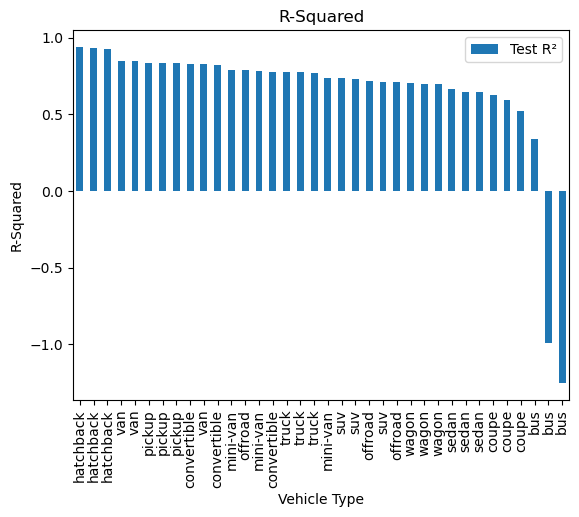

In [151]:
# r-Squared plot
rSquaredsorted.plot.bar(x='Vehicle Type', y=['Test R²'])
plt.title('R-Squared')
plt.xlabel('Vehicle Type')
plt.ylabel('R-Squared')

# Save the plot as a PNG file
file_path = ('images/rSquared')
plt.savefig(file_path)

#Show the plot
plt.show()

The R-squared value of >75% may indicate that the regression model fits the data. In this case the vehicle types that have a good R-squared value are hatchbacks, vans, pickups, convertibles, trucks and minivans despite the regression model selected. As each vehicle type is different, the regression models associated with them provide the R-squared value that helps suggest a better fit.  For example:  For hatchbacks, pickups, convertibles, the best regression model that fits the data is the lasso.

Sedans, busses and coupes do not have a suitable regression model that seems to fit so well.

In [152]:
#Cross Validation - Model used is GridSearchCV

#initialize empty dataframe
iniDF = pd.DataFrame()

# Loop through the names and access the DataFrames
for name in dfList:
    df = globals()[name]
    position = 8
    vehiclesplit = name[position:]
    
    if vehiclesplit == 'MiniVan':
        type = 'mini-van'
    else:
        type = vehiclesplit.lower()

    #features and target
    
    train = df
    test = df.drop('price', axis =1)

    X = train.drop('price', axis =1)
    y = train['price']

    #Train test splitting
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state = 42)


    # Building a preprocessing pipeline
    numericalCols = X.select_dtypes(include=['int64', 'float64']).columns
    categoricalCols = X.select_dtypes(include=['object']).columns

    #define separate pipelines for numerical and categorical features.
    preprocessor = ColumnTransformer(transformers=[('num', StandardScaler(), numericalCols),
                                                   ('cat', OneHotEncoder(handle_unknown='ignore'), categoricalCols)])

    model = Pipeline(steps=[("preprocessor", preprocessor), ("regressor", Lasso(alpha=0.001))])
    param_grid = {'regressor__alpha': [0.001, 0.01, 0.1, 1, 10]}
    # Grid search
    model = GridSearchCV(model, param_grid, cv=5, scoring="neg_root_mean_squared_error")

    model.fit(X_train, y_train)
    bestAlpha = model.best_params_["regressor__alpha"]
    cvRMSE = -model.best_score_

    #make predictions
    y_pred = model.predict(X_test)

    #Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    #summary
    summary = {
        "Vehicle Type": type,
        "Features Train": X_train.shape,
        "Features Test": X_test.shape,
        "Target Train": y_train.shape,
        "Target Test": y_test.shape,
        "Best alpha": bestAlpha,
        "Test MSE": mse,
        "CV RMSE": cvRMSE,
        "Test RMSE": rmse,
        "Test R²": r2}

    #create dataframe of the summary and append to empty dataframe and subsequently to new dataframe
        
    regCV = pd.concat([iniDF, pd.DataFrame([summary])])

    iniDF = regCV

In [153]:
#Cross validation results
iniDF

,Vehicle Type,Features Train,Features Test,Target Train,Target Test,Best alpha,Test MSE,CV RMSE,Test RMSE,Test R²
0,pickup,"(1896, 10)","(474, 10)","(1896,)","(474,)",1.000,3.575007e+07,6251.843813,5979.136031,0.835252
0,coupe,"(838, 10)","(210, 10)","(838,)","(210,)",10.000,7.037029e+07,11315.864436,8388.699894,0.622499
0,suv,"(6497, 10)","(1625, 10)","(6497,)","(1625,)",1.000,2.892912e+07,5674.299515,5378.579822,0.731792
0,sedan,"(5981, 10)","(1496, 10)","(5981,)","(1496,)",1.000,1.789450e+07,4452.002276,4230.188557,0.646909
0,convertible,"(367, 10)","(92, 10)","(367,)","(92,)",10.000,2.344440e+07,6940.276664,4841.941868,0.830400
0,truck,"(5016, 10)","(1254, 10)","(5016,)","(1254,)",1.000,4.125925e+07,6331.067314,6423.336510,0.774399
0,hatchback,"(840, 10)","(210, 10)","(840,)","(210,)",10.000,6.336517e+06,3360.059898,2517.243837,0.938772
0,wagon,"(581, 10)","(146, 10)","(581,)","(146,)",10.000,1.206555e+07,2807.921919,3473.549404,0.694338
0,van,"(1246, 10)","(312, 10)","(1246,)","(312,)",10.000,2.092068e+07,5350.008430,4573.912826,0.829737
0,mini-van,"(436, 10)","(109, 10)","(436,)","(109,)",10.000,1.340575e+07,4650.696003,3661.386377,0.783008


In [154]:
# Write to CSV
iniDF.to_csv('output/crossValidationDF.csv', index=False)

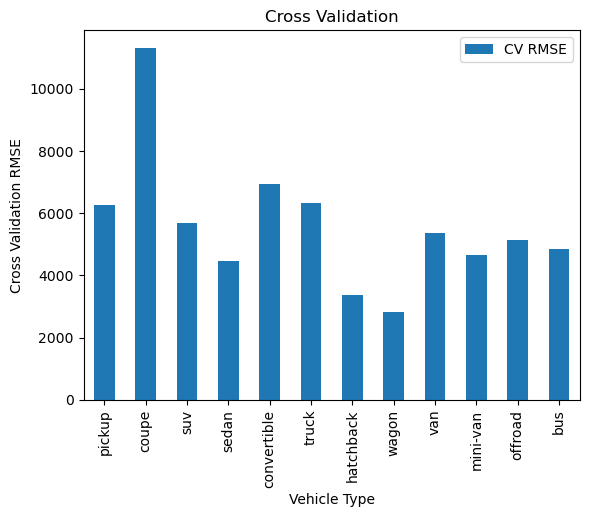

In [155]:
#Cross Validation plot

iniDF.plot.bar(x='Vehicle Type', y=['CV RMSE'])
plt.title('Cross Validation')
plt.xlabel('Vehicle Type')
plt.ylabel('Cross Validation RMSE')

# Save the plot as a PNG file
file_path = ('images/crossvalidation')
plt.savefig(file_path)

#Show the plot
plt.show()

The results from the cross validation indicate that the model with the Wagons using an alpha of 10 provides a reliable estimate on unseen data. The model with 'coupe' is less reliable to new information.

In [157]:
# Correlation strength of numerical features on price

corrDF=[]

for name in dfList:
    df = globals()[name]
    position = 8
    vehiclesplit = name[position:]
    
    if vehiclesplit == 'MiniVan':
        type = 'mini-van'
    else:
        type = vehiclesplit.lower()

    #features and target    
    train = df
    test = df.drop('price', axis =1)

    X = train.drop('price', axis =1)
    y = train['price']

    #Train test splitting
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state = 42)


    trainCorr = X_train.copy()
    trainCorr['price'] = y_train

    # Compute correlation matrix and extract correlations with 'price'
    correlations = trainCorr.corr(numeric_only=True)['price'].drop('price')

    # Sort by absolute correlation in descending order
    sortedCorr = correlations.abs().sort_values(ascending=False)

    #summary
    summary = {
        "Vehicle Type": type,
        "Absolute Correlation": sortedCorr}

    print(summary)
    

{'Vehicle Type': 'pickup', 'Absolute Correlation': age         0.707882
odometer    0.558302
Name: price, dtype: float64}
{'Vehicle Type': 'coupe', 'Absolute Correlation': odometer    0.496930
age         0.403091
Name: price, dtype: float64}
{'Vehicle Type': 'suv', 'Absolute Correlation': age         0.624216
odometer    0.569380
Name: price, dtype: float64}
{'Vehicle Type': 'sedan', 'Absolute Correlation': age         0.470688
odometer    0.465153
Name: price, dtype: float64}
{'Vehicle Type': 'convertible', 'Absolute Correlation': odometer    0.639168
age         0.407424
Name: price, dtype: float64}
{'Vehicle Type': 'truck', 'Absolute Correlation': age         0.547738
odometer    0.471767
Name: price, dtype: float64}
{'Vehicle Type': 'hatchback', 'Absolute Correlation': age         0.588012
odometer    0.546362
Name: price, dtype: float64}
{'Vehicle Type': 'wagon', 'Absolute Correlation': age         0.177179
odometer    0.107582
Name: price, dtype: float64}
{'Vehicle Type': 'van',

The main features that impact the price of the vehicle are the age and the odometer reading.  Pickups, Vans, Mini-Vans, and Offroad vehicles seem to depreciate the fastest with age.  Convertibles and buses seem to be impacted more by the odometer reading.

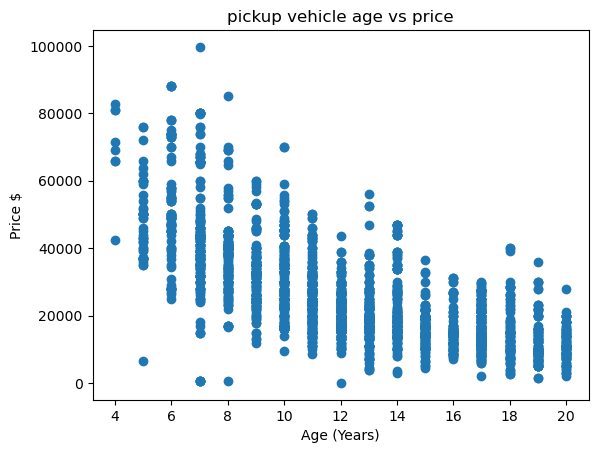

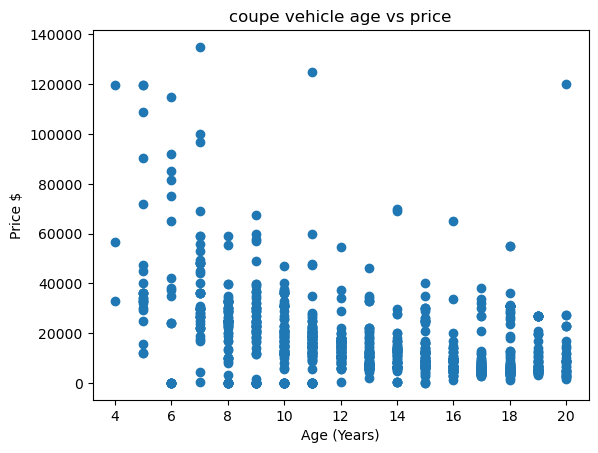

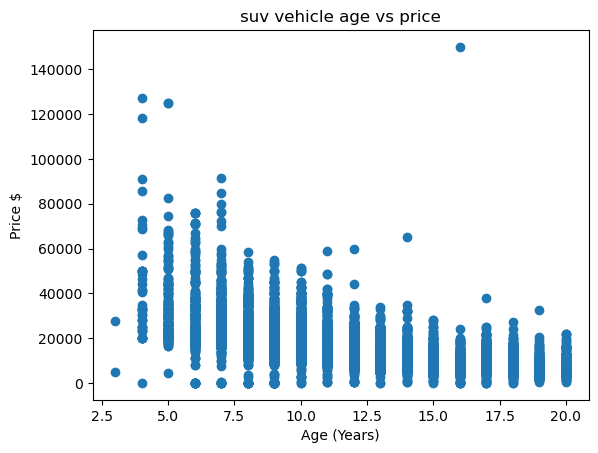

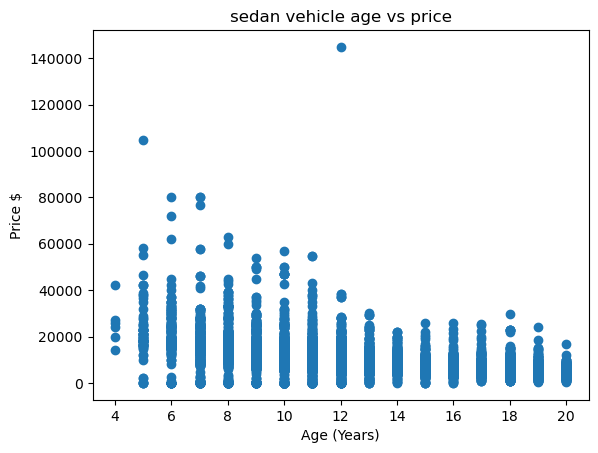

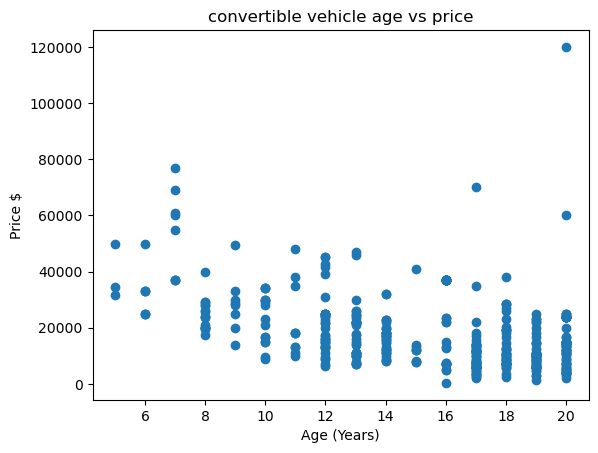

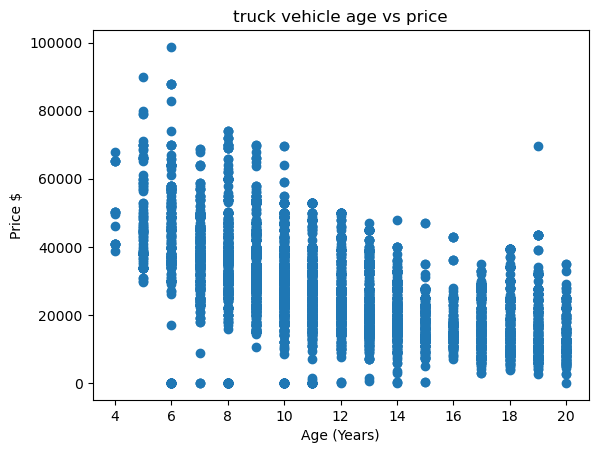

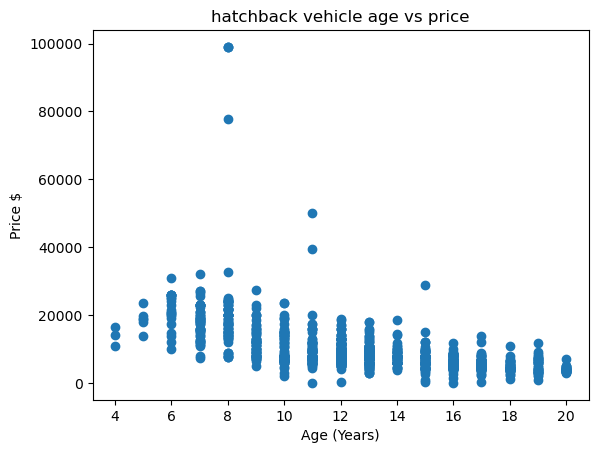

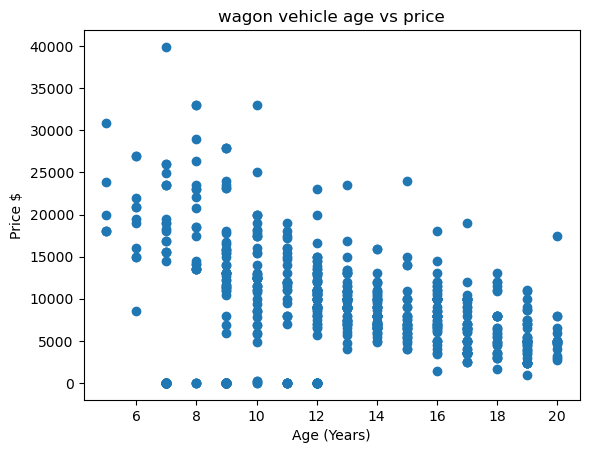

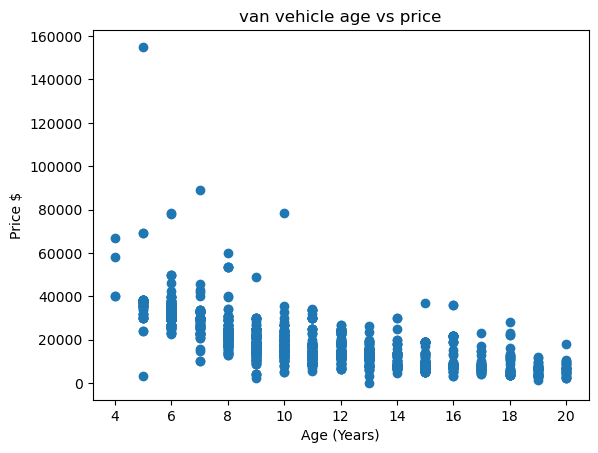

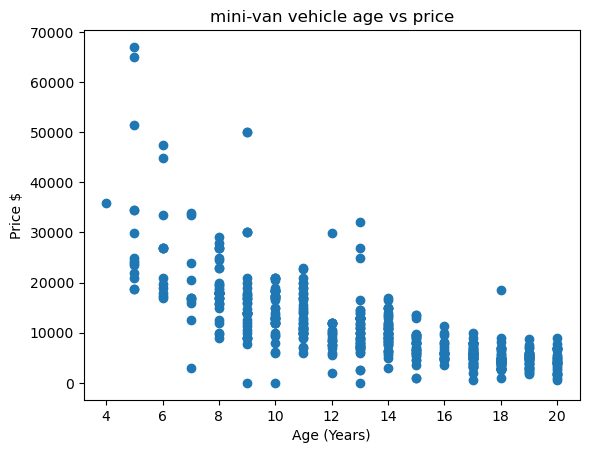

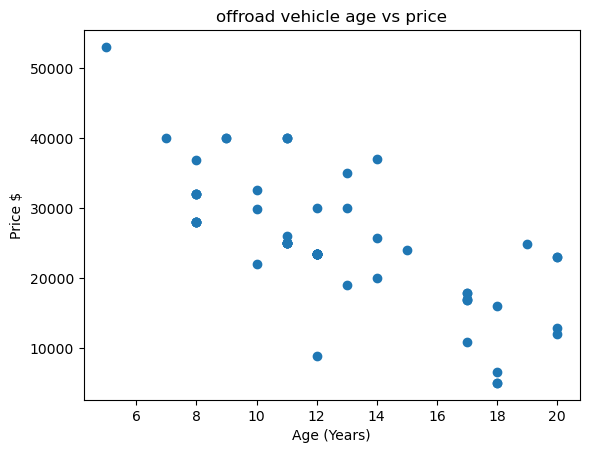

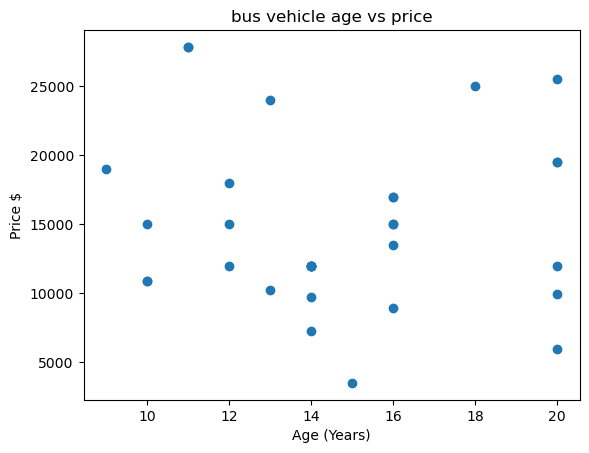

In [98]:
# Impact of vehicle age on price

ageDF=[]

for name in dfList:
    df = globals()[name]
    position = 8
    vehiclesplit = name[position:]
    
    if vehiclesplit == 'MiniVan':
        type = 'mini-van'
    else:
        type = vehiclesplit.lower()


    X = df['age']
    y = df['price']


    plt.scatter(X, y)
    plt.title(type+' vehicle age vs price')
    plt.xlabel("Age (Years)")
    plt.ylabel("Price $")
    plt.show()



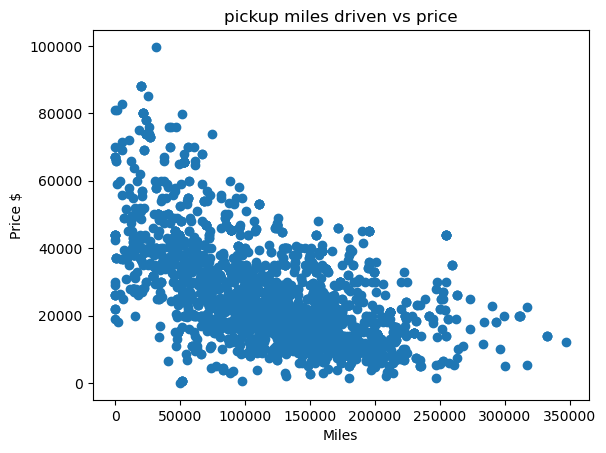

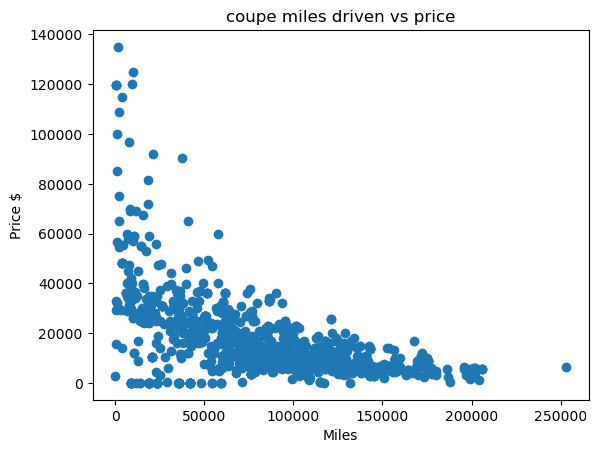

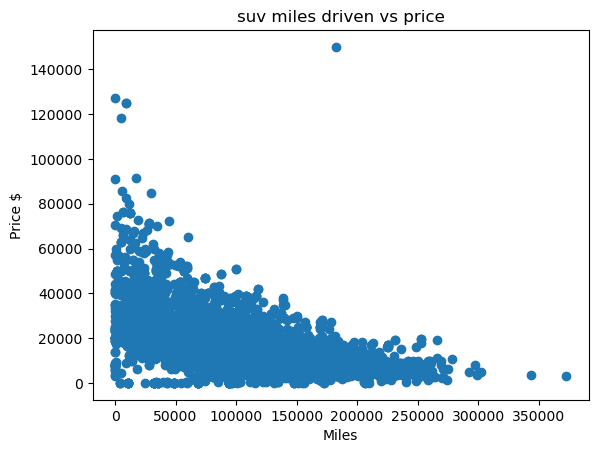

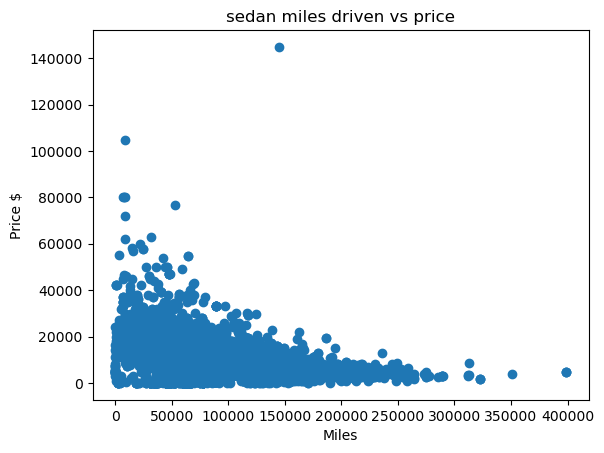

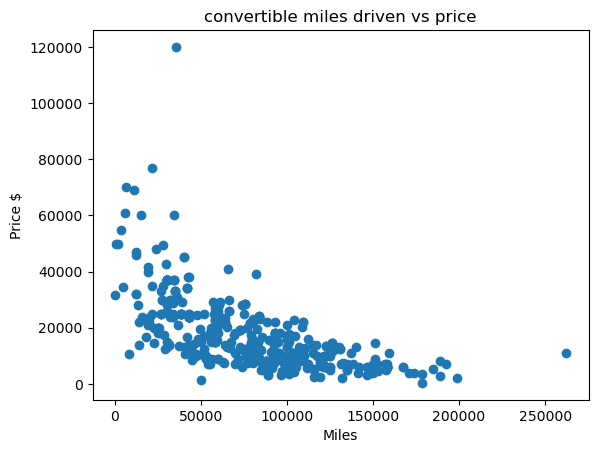

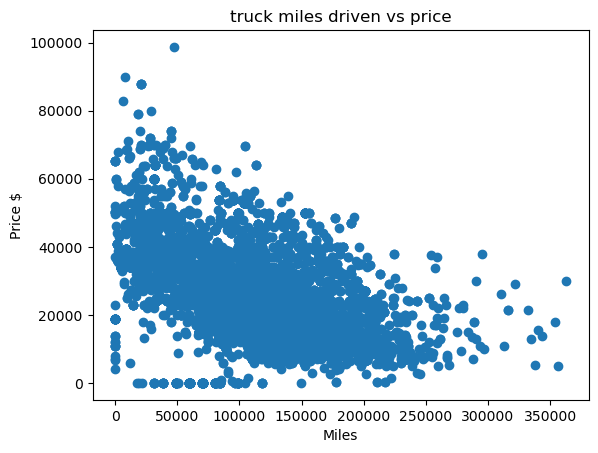

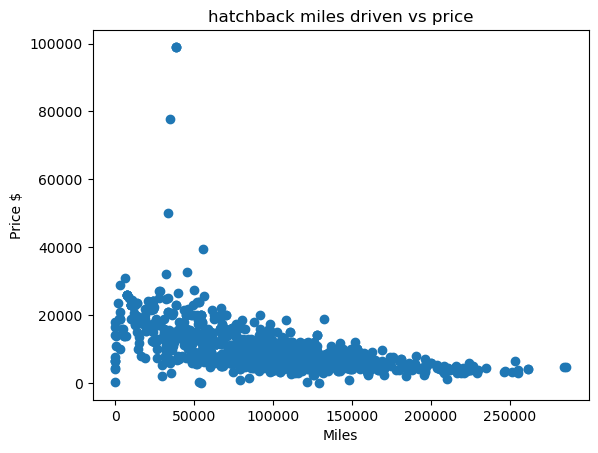

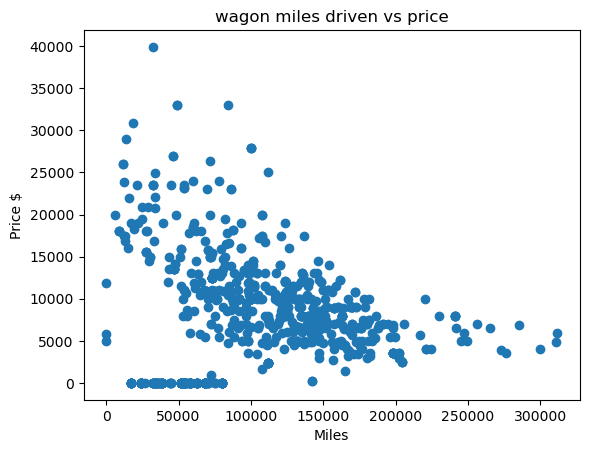

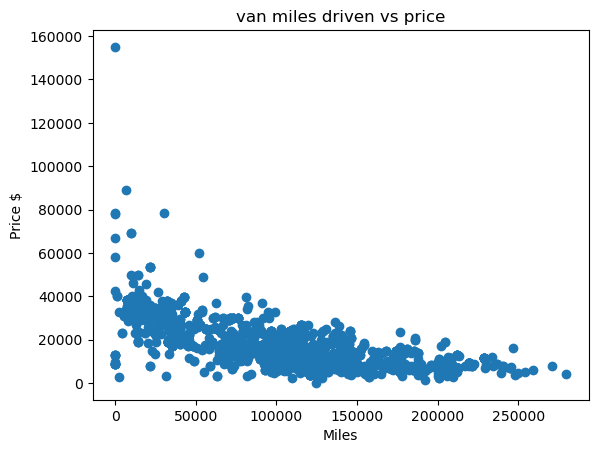

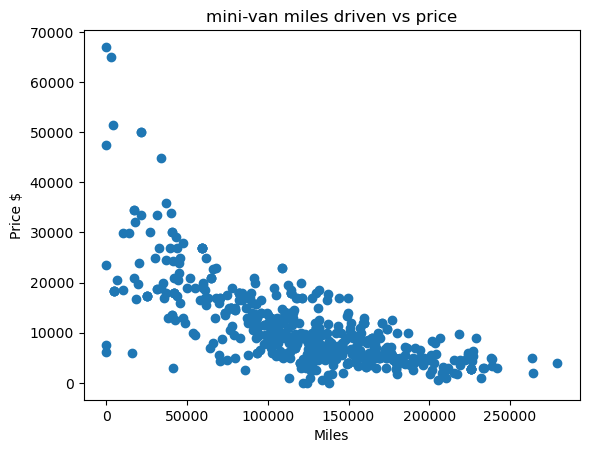

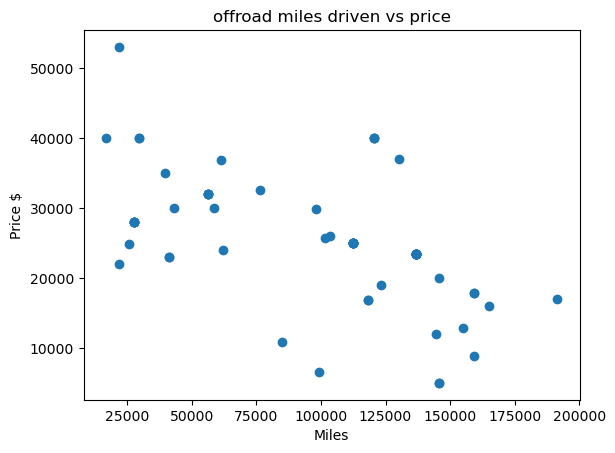

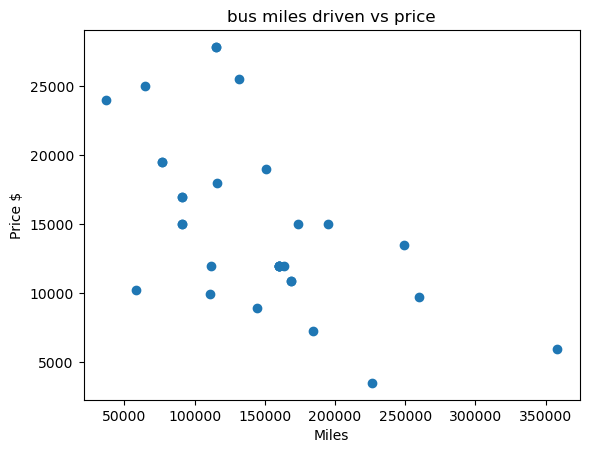

In [96]:
# Impact of odometer readng on price

ageDF=[]

for name in dfList:
    df = globals()[name]
    position = 8
    vehiclesplit = name[position:]
    
    if vehiclesplit == 'MiniVan':
        type = 'mini-van'
    else:
        type = vehiclesplit.lower()


    X = df['odometer']
    y = df['price']


    plt.scatter(X, y)
    plt.title(type+' miles driven vs price')
    plt.xlabel("Miles")
    plt.ylabel("Price $")
    plt.show()

In [88]:
#Feature importance


for name in dfList:
    df = globals()[name]
    position = 8
    vehiclesplit = name[position:]
    
    if vehiclesplit == 'MiniVan':
        type = 'mini-van'
    else:
        type = vehiclesplit.lower()

    # Identify numerical and categorical features
    numerical_features = df.select_dtypes(include=['int64', 'float64']).columns
    categorical_features = df.select_dtypes(include=['object']).columns

    # Separate features and target
    X = df.drop('price', axis=1)
    y = df['price']

    # Encode categorical features (using Target Encoding as an example)
    encoder = ce.TargetEncoder(cols=categorical_features)
    X[categorical_features] = encoder.fit_transform(X[categorical_features], y)

    # Calculate mutual information scores
    mi_scores = mutual_info_classif(X, y)

    # Create a DataFrame to store feature names and scores
    feature_importance = pd.DataFrame({'Vehicle Type': type, 'Feature': X.columns, 'Mutual_Information_Score': mi_scores})
    
    # dataframes[type] = feature_importance

    # Rank features by Mutual Information score
    feature_importance = feature_importance.sort_values(by='Mutual_Information_Score', ascending=False)

    # Write to CSV
    feature_importance.to_csv('output/'+type+'.csv', index=False)
    
    print(feature_importance)


  Vehicle Type       Feature  Mutual_Information_Score
6       pickup  transmission                  2.383747
8       pickup          size                  2.372807
1       pickup      odometer                  2.367615
4       pickup          fuel                  2.240797
5       pickup         Model                  2.204610
7       pickup         drive                  2.041079
0       pickup           age                  1.906676
3       pickup     cylinders                  1.820438
2       pickup  manufacturer                  1.557518
9       pickup         state                  1.433058
  Vehicle Type       Feature  Mutual_Information_Score
4        coupe          fuel                  2.902600
6        coupe  transmission                  2.366720
7        coupe         drive                  2.259909
1        coupe      odometer                  2.154319
5        coupe         Model                  2.064816
3        coupe     cylinders                  1.800788
0        c

### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine-tuning their inventory.

a) The main features that impact the price of the vehicle are the vehicle age and the odometer reading. Pickups, Vans, Mini-Vans, and Offroad vehicles seem to depreciate the fastest with age. Convertibles and buses seem to be impacted more by the odometer reading.  Additional top three features that impact price:

    -Pickups: Transmission, size, and fuel type
    -Vans: Model, transmission and size
    -Mini-Vans: Fuel type, transmission, and drive
    -Offroad:  Model, State, and size
    -Sedans: Model, transmission, and fuel type
    -Convertibles: Fuel type, Model, and transmission
    -Trucks: Model, age, and transmission
    -Hatchback: cylinders, fuel type, and drive
    -Wagon: transmission, model, and fuel
    -Bus: transmission, model, and cylinder
    -SUV: Model, transmission, and fuel type
    -Coupe: Fuel type, transmission, and drive

Maintaining the appropriate inventory of the vehicles based on the important features that impact the price will help sell the vehicles at a higher price.  Vehicle age and odometer reading are the key features overall.  Trucks have the best correlation of odometer reading to the price.

b) There is a more reliable price prediction based on the available inventory for hatchbacks, vans, pickups, convertibles, trucks, and minivans which may suggest faster sales cycles.

c) Pricing on new unknown inventory can be better predicted for wagons, hatchbacks, and sedans.